# Baseline

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.cm as cm
import numpy as np

In [2]:
def calculate_size(size, kernel_size, stride):
    return (size - kernel_size) // stride + 1

In [3]:
class BaseLineModel(nn.Module):
    def __init__(self, kernel_num = 10, kernel_size = 5, dropout_rate = 0.5, pool_size = 2, activation_func = F.relu, hidden_nodes = 50, training_epoch = 5, batch_size = 64):
        super(BaseLineModel, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.pool_size = pool_size
        self.activation_func = activation_func
        self.hidden_nodes = hidden_nodes

        self.fc_input_size = calculate_size(28, self.kernel_size, 1)
        self.fc_input_size = calculate_size(self.fc_input_size, self.pool_size, self.pool_size)
        self.fc_input_size = calculate_size(self.fc_input_size, self.kernel_size, 1)
        self.fc_input_size = calculate_size(self.fc_input_size, 2, 2)
        self.fc_input_size = 20 * self.fc_input_size * self.fc_input_size
        # print(f'first full connected layer input size: {self.fc_input_size}')

        self.n_epochs = training_epoch
        self.batch_size_train = batch_size
        self.batch_size_test = 1000
        self.learning_rate = 0.01
        self.momentum = 0.5
        self.log_interval = 10
        self.random_seed = 42

        torch.backends.cudnn.enabled = False
        torch.manual_seed(self.random_seed)

        # load the training dataset and test dataset
        self.train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True,
                                                        transform=torchvision.transforms.Compose([
                                                            torchvision.transforms.ToTensor(),
                                                            torchvision.transforms.Normalize(
                                                                (0.1307,), (0.3081,))
                                                        ]))
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size_train)
        self.test_dataset = torchvision.datasets.MNIST('../data', train=False, download=True,
                                                       transform=torchvision.transforms.Compose([
                                                           torchvision.transforms.ToTensor(),
                                                           torchvision.transforms.Normalize(
                                                               (0.1307,), (0.3081,))
                                                       ]))
        self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size_test)

        # define the layers
        self.conv1 = nn.Conv2d(1, self.kernel_num, kernel_size=(self.kernel_size, self.kernel_size))
        self.conv2 = nn.Conv2d(self.kernel_num, 20, kernel_size=(self.kernel_size, self.kernel_size))
        self.conv2_drop = nn.Dropout2d(p=self.dropout_rate)
        self.fc1 = nn.Linear(self.fc_input_size, self.hidden_nodes)
        self.fc2 = nn.Linear(self.hidden_nodes, 10)

    def forward(self, x):
        """
        computes a forward pass for the network
        :param x: feed data
        :return: 10 values indicating the confidence of the data towards labels
        """
        x = self.activation_func(F.max_pool2d(self.conv1(x), self.pool_size))
        x = self.activation_func(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.fc_input_size)
        x = self.activation_func(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [4]:
def train_network(network, epoch, train_losses, train_counter, model_pth, opt_pth):
    """
    Train the network on the training dataset, calculate the loss values.
    :param network: the network that is during training
    :param epoch: the training epoch
    :param train_losses: the training loss values in a list
    :param train_counter: the counter for training
    """
    optimizer = optim.SGD(network.parameters(), lr=network.learning_rate,
                          momentum=network.momentum)

    network.train()
    for batch_idx, (data, target) in enumerate(network.train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % network.log_interval == 0:
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(data), len(network.train_loader.dataset),
            #            100. * batch_idx / len(network.train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(network.train_loader.dataset)))
            torch.save(network.state_dict(), f'../results/{model_pth}.pth')
            torch.save(optimizer.state_dict(), f'../results/{opt_pth}.pth')


def test_network(network, test_losses):
    """
    Test the network performance on the test dataset, calculate the corresponding loss.
    :param network: the network that is during training
    :param test_losses: the loss values on the test dataset
    """
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in network.test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(network.test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(network.test_loader.dataset),
        100. * correct / len(network.test_loader.dataset)))
    return correct

def train_process(network, model_pth, opt_pth):
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i * len(network.train_loader.dataset) for i in range(network.n_epochs + 1)]
    accuracies = []

    correct_num = test_network(network, test_losses)
    accuracies.append(correct_num / len(network.test_loader.dataset))
    total_time = 0
    train_start_time = time.time()
    for epoch in range(1, network.n_epochs + 1):
        train_network(network, epoch, train_losses, train_counter, model_pth, opt_pth)
        correct_num = test_network(network, test_losses)
        accuracies.append(correct_num / len(network.test_loader.dataset))
        print(f'Epoch {epoch} takes: {time.time() - train_start_time}s')
        total_time += (time.time() - train_start_time)

    print(f'Average time per epoch: {total_time / network.n_epochs}s')
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()
    return train_losses, train_counter, test_counter, test_losses, accuracies, total_time, total_time / network.n_epochs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2159, Accuracy: 9341/10000 (93%)
Epoch 1 takes: 34.74180340766907s

Test set: Avg. loss: 0.1305, Accuracy: 9586/10000 (96%)
Epoch 2 takes: 60.9398307800293s

Test set: Avg. loss: 0.1061, Accuracy: 9684/10000 (97%)
Epoch 3 takes: 86.90236234664917s

Test set: Avg. loss: 0.0908, Accuracy: 9730/10000 (97%)
Epoch 4 takes: 113.1948094367981s

Test set: Avg. loss: 0.0828, Accuracy: 9743/10000 (97%)
Epoch 5 takes: 139.86180090904236s
Average time per epoch: 87.1282546043396s


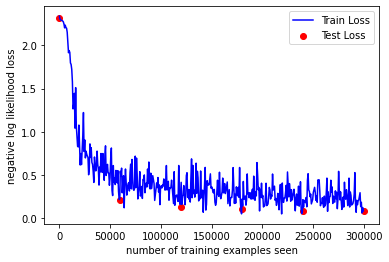

In [5]:
    baseline_model = BaseLineModel()
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, avg_time = train_process(baseline_model, 'baseline', 'baseline_opt')

---
# Experiment-1: The size of the convolution filters
#### Hypothesis
Larger kernel should learn more features and more translation-invariant than small kernels, which should lead to bigger accuracy. However, when the kernel size is approaching the image size, the accuracy should decrease due to the lack of information.
#### Observation
The accuracy plot shows the model with kernel size as 6 performs best out of the six models. The accuracy of those models increases as the kernel size increases from 2 to 6. Then the model with convolutional kernel size as 7 performs worse than the those with kernels size from 3 to 6, which  indicates kernel size as 6 in this task may be the optimal choice.

2 2_opt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2927, Accuracy: 1476/10000 (15%)

Test set: Avg. loss: 0.2957, Accuracy: 9095/10000 (91%)
Epoch 1 takes: 21.831963062286377s

Test set: Avg. loss: 0.1971, Accuracy: 9384/10000 (94%)
Epoch 2 takes: 43.94180250167847s

Test set: Avg. loss: 0.1568, Accuracy: 9520/10000 (95%)
Epoch 3 takes: 65.5998809337616s

Test set: Avg. loss: 0.1357, Accuracy: 9568/10000 (96%)
Epoch 4 takes: 87.2887761592865s

Test set: Avg. loss: 0.1198, Accuracy: 9621/10000 (96%)
Epoch 5 takes: 108.96653413772583s
Average time per epoch: 65.52611389160157s


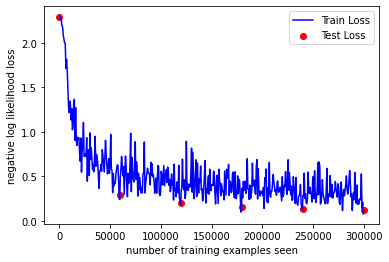

3 3_opt

Test set: Avg. loss: 2.3116, Accuracy: 953/10000 (10%)

Test set: Avg. loss: 0.2709, Accuracy: 9173/10000 (92%)
Epoch 1 takes: 23.447916746139526s

Test set: Avg. loss: 0.1749, Accuracy: 9455/10000 (95%)
Epoch 2 takes: 46.93007802963257s

Test set: Avg. loss: 0.1298, Accuracy: 9610/10000 (96%)
Epoch 3 takes: 70.40611624717712s

Test set: Avg. loss: 0.1069, Accuracy: 9676/10000 (97%)
Epoch 4 takes: 93.87066006660461s

Test set: Avg. loss: 0.0970, Accuracy: 9713/10000 (97%)
Epoch 5 takes: 119.42962694168091s
Average time per epoch: 70.81718244552613s


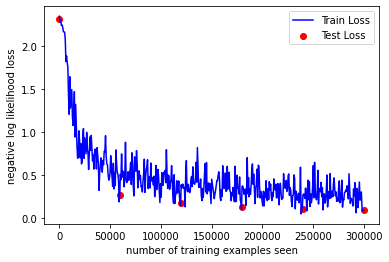

4 4_opt

Test set: Avg. loss: 2.3026, Accuracy: 996/10000 (10%)

Test set: Avg. loss: 0.2460, Accuracy: 9239/10000 (92%)
Epoch 1 takes: 23.985366821289062s

Test set: Avg. loss: 0.1415, Accuracy: 9556/10000 (96%)
Epoch 2 takes: 47.916319608688354s

Test set: Avg. loss: 0.1112, Accuracy: 9649/10000 (96%)
Epoch 3 takes: 71.91579461097717s

Test set: Avg. loss: 0.0964, Accuracy: 9696/10000 (97%)
Epoch 4 takes: 95.92923831939697s

Test set: Avg. loss: 0.0838, Accuracy: 9736/10000 (97%)
Epoch 5 takes: 120.85830807685852s
Average time per epoch: 72.12130160331726s


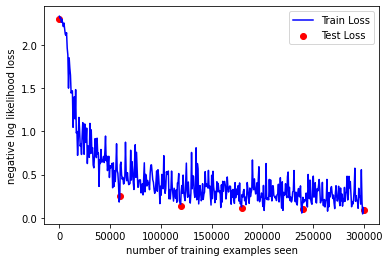

5 5_opt

Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2136, Accuracy: 9357/10000 (94%)
Epoch 1 takes: 26.06310749053955s

Test set: Avg. loss: 0.1397, Accuracy: 9560/10000 (96%)
Epoch 2 takes: 52.13020133972168s

Test set: Avg. loss: 0.1096, Accuracy: 9641/10000 (96%)
Epoch 3 takes: 78.13285422325134s

Test set: Avg. loss: 0.0912, Accuracy: 9714/10000 (97%)
Epoch 4 takes: 104.19282913208008s

Test set: Avg. loss: 0.0800, Accuracy: 9748/10000 (97%)
Epoch 5 takes: 130.22332882881165s
Average time per epoch: 78.14868812561035s


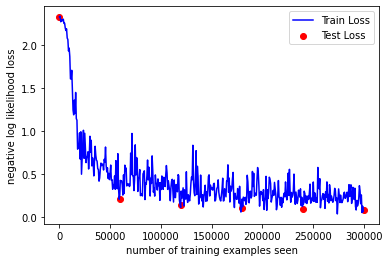

6 6_opt

Test set: Avg. loss: 2.3049, Accuracy: 1009/10000 (10%)

Test set: Avg. loss: 0.2006, Accuracy: 9399/10000 (94%)
Epoch 1 takes: 25.68428325653076s

Test set: Avg. loss: 0.1199, Accuracy: 9625/10000 (96%)
Epoch 2 takes: 51.47114181518555s

Test set: Avg. loss: 0.0970, Accuracy: 9701/10000 (97%)
Epoch 3 takes: 77.25042939186096s

Test set: Avg. loss: 0.0860, Accuracy: 9736/10000 (97%)
Epoch 4 takes: 102.98170137405396s

Test set: Avg. loss: 0.0731, Accuracy: 9777/10000 (98%)
Epoch 5 takes: 128.72487783432007s
Average time per epoch: 77.22276148796081s


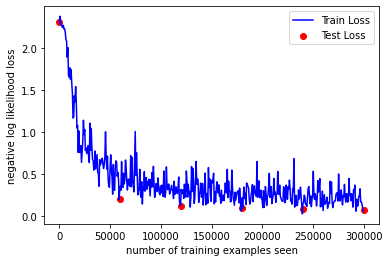

7 7_opt

Test set: Avg. loss: 2.3100, Accuracy: 1014/10000 (10%)

Test set: Avg. loss: 0.2815, Accuracy: 9135/10000 (91%)
Epoch 1 takes: 26.469634771347046s

Test set: Avg. loss: 0.1688, Accuracy: 9485/10000 (95%)
Epoch 2 takes: 53.64787721633911s

Test set: Avg. loss: 0.1310, Accuracy: 9605/10000 (96%)
Epoch 3 takes: 80.19784927368164s

Test set: Avg. loss: 0.1030, Accuracy: 9688/10000 (97%)
Epoch 4 takes: 106.64602398872375s

Test set: Avg. loss: 0.0957, Accuracy: 9696/10000 (97%)
Epoch 5 takes: 132.997661113739s
Average time per epoch: 79.99226875305176s


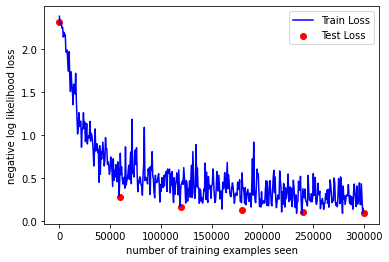

In [6]:
first_experiment_models = [BaseLineModel(kernel_size=i) for i in range(2, 8, 1)]
first_experiment_test_losses = []
first_experiment_accuracies = []
first_experiment_avg_time = []
for model in first_experiment_models:
    print(str(model.kernel_size), str(model.kernel_size) + '_opt')
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp1_{model.kernel_size}', f'exp1_{model.kernel_size}_opt')
    first_experiment_test_losses.append(test_losses)
    first_experiment_accuracies.append(accuracies)
    first_experiment_avg_time.append(average_time)

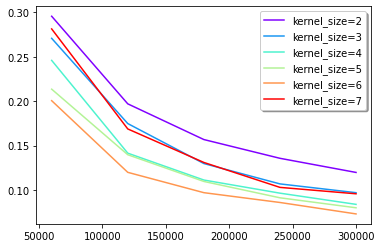

In [7]:
colors = cm.rainbow(np.linspace(0, 1, len(first_experiment_test_losses)))

idx = 2
fig, ax = plt.subplots()
for loss, color in zip(first_experiment_test_losses, colors):
    ax.plot(test_counter[1:], loss[1:], color=color, label='kernel_size=' + str(idx))
    idx += 1
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

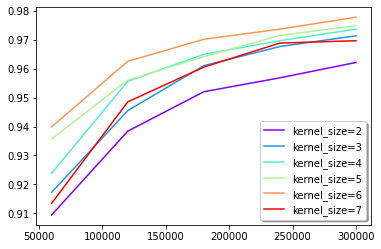

In [8]:
idx = 2
fig, ax = plt.subplots()
for acc, color in zip(first_experiment_accuracies, colors):
    ax.plot(test_counter[1:], acc[1:], color=color, label='kernel_size=' + str(idx))
    idx += 1
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-2: The number of convolution filters in a layer
#### Hypothesis
More kernels in the first convolutional layer should learn more features and increase the accuracy, and it should take more time for training.
#### Observation
I tried the kernel numbers: 5, 7, 9, 11, 13, 15 for the first convolutional layer. The result shows the model with 13 kernels get the best performance and the model with 9 kernels get the worst performance. The accuracy of the other four models are all around 97.2%. Taking the training time into account, I would suggest the 7 or 13 is the best choice.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3265, Accuracy: 480/10000 (5%)

Test set: Avg. loss: 0.2072, Accuracy: 9351/10000 (94%)
Epoch 1 takes: 19.557823181152344s

Test set: Avg. loss: 0.1311, Accuracy: 9580/10000 (96%)
Epoch 2 takes: 38.966474771499634s

Test set: Avg. loss: 0.1016, Accuracy: 9696/10000 (97%)
Epoch 3 takes: 58.30793786048889s

Test set: Avg. loss: 0.0890, Accuracy: 9717/10000 (97%)
Epoch 4 takes: 77.71786403656006s

Test set: Avg. loss: 0.0797, Accuracy: 9761/10000 (98%)
Epoch 5 takes: 97.08972787857056s
Average time per epoch: 58.32829308509827s


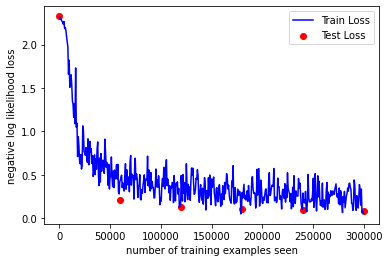


Test set: Avg. loss: 2.3011, Accuracy: 1042/10000 (10%)

Test set: Avg. loss: 0.1951, Accuracy: 9391/10000 (94%)
Epoch 1 takes: 20.223240852355957s

Test set: Avg. loss: 0.1226, Accuracy: 9625/10000 (96%)
Epoch 2 takes: 40.60001587867737s

Test set: Avg. loss: 0.0967, Accuracy: 9688/10000 (97%)
Epoch 3 takes: 60.990342140197754s

Test set: Avg. loss: 0.0833, Accuracy: 9737/10000 (97%)
Epoch 4 takes: 81.326895236969s

Test set: Avg. loss: 0.0760, Accuracy: 9765/10000 (98%)
Epoch 5 takes: 101.69498109817505s
Average time per epoch: 60.967305707931516s


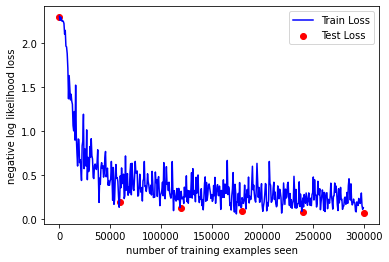


Test set: Avg. loss: 2.3134, Accuracy: 1006/10000 (10%)

Test set: Avg. loss: 0.2445, Accuracy: 9236/10000 (92%)
Epoch 1 takes: 25.311323642730713s

Test set: Avg. loss: 0.1475, Accuracy: 9534/10000 (95%)
Epoch 2 takes: 50.66882133483887s

Test set: Avg. loss: 0.1156, Accuracy: 9634/10000 (96%)
Epoch 3 takes: 75.94572043418884s

Test set: Avg. loss: 0.0970, Accuracy: 9683/10000 (97%)
Epoch 4 takes: 101.32014083862305s

Test set: Avg. loss: 0.0823, Accuracy: 9735/10000 (97%)
Epoch 5 takes: 126.6242368221283s
Average time per epoch: 75.97420387268066s


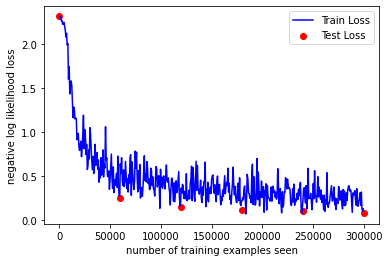


Test set: Avg. loss: 2.3044, Accuracy: 1026/10000 (10%)

Test set: Avg. loss: 0.2341, Accuracy: 9272/10000 (93%)
Epoch 1 takes: 26.089880228042603s

Test set: Avg. loss: 0.1435, Accuracy: 9541/10000 (95%)
Epoch 2 takes: 52.05625581741333s

Test set: Avg. loss: 0.1112, Accuracy: 9650/10000 (96%)
Epoch 3 takes: 77.96062445640564s

Test set: Avg. loss: 0.0935, Accuracy: 9704/10000 (97%)
Epoch 4 takes: 104.03154373168945s

Test set: Avg. loss: 0.0804, Accuracy: 9755/10000 (98%)
Epoch 5 takes: 130.0958685874939s
Average time per epoch: 78.04706873893738s


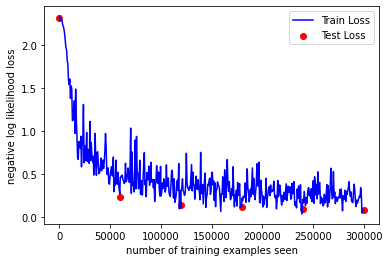


Test set: Avg. loss: 2.3039, Accuracy: 983/10000 (10%)

Test set: Avg. loss: 0.2045, Accuracy: 9387/10000 (94%)
Epoch 1 takes: 26.739566564559937s

Test set: Avg. loss: 0.1227, Accuracy: 9624/10000 (96%)
Epoch 2 takes: 53.72551774978638s

Test set: Avg. loss: 0.0996, Accuracy: 9692/10000 (97%)
Epoch 3 takes: 80.55705618858337s

Test set: Avg. loss: 0.0801, Accuracy: 9741/10000 (97%)
Epoch 4 takes: 107.47764086723328s

Test set: Avg. loss: 0.0707, Accuracy: 9788/10000 (98%)
Epoch 5 takes: 134.22862362861633s
Average time per epoch: 80.54588394165039s


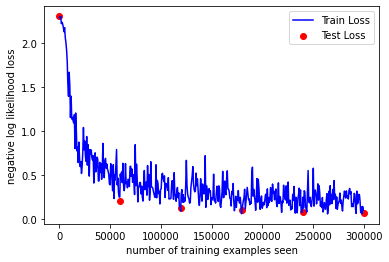


Test set: Avg. loss: 2.3097, Accuracy: 1139/10000 (11%)

Test set: Avg. loss: 0.1939, Accuracy: 9415/10000 (94%)
Epoch 1 takes: 27.73126482963562s

Test set: Avg. loss: 0.1251, Accuracy: 9611/10000 (96%)
Epoch 2 takes: 55.925713300704956s

Test set: Avg. loss: 0.1002, Accuracy: 9669/10000 (97%)
Epoch 3 takes: 84.12013101577759s

Test set: Avg. loss: 0.0834, Accuracy: 9724/10000 (97%)
Epoch 4 takes: 112.29103565216064s

Test set: Avg. loss: 0.0736, Accuracy: 9747/10000 (97%)
Epoch 5 takes: 140.43098378181458s
Average time per epoch: 84.10012483596802s


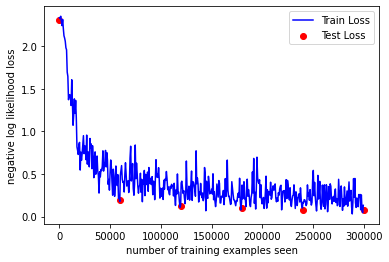

In [9]:
second_experiment_models = [BaseLineModel(kernel_num=i) for i in range(5, 17, 2)]
second_experiment_test_losses = []
second_experiment_accuracies = []
second_experiment_avg_time = []
for model in second_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp2_{model.kernel_num}', f'exp2_{model.kernel_num}_opt')
    second_experiment_test_losses.append(test_losses)
    second_experiment_accuracies.append(accuracies)
    second_experiment_avg_time.append(average_time)

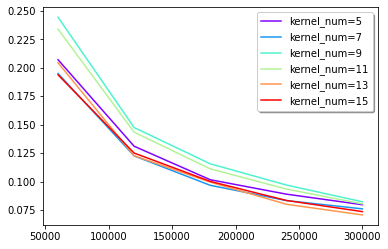

In [10]:
second_experiment_list = [i for i in range(5, 17, 2)]
colors = cm.rainbow(np.linspace(0, 1, len(second_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, kernel_num in zip(second_experiment_test_losses, colors, second_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='kernel_num=' + str(kernel_num))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

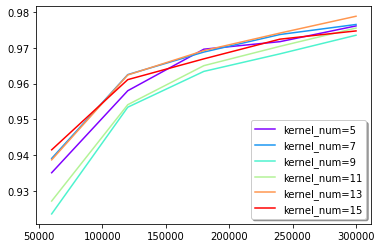

In [11]:
fig, ax = plt.subplots()
for acc, color, kernel_num in zip(second_experiment_accuracies, colors, second_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='kernel_num=' + str(kernel_num))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

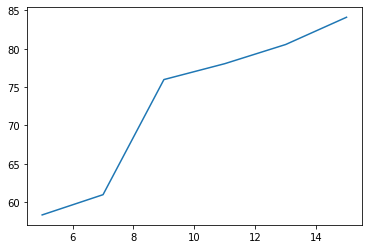

In [12]:
plt.plot(second_experiment_list, second_experiment_avg_time)
plt.show()

---
# Experiment-3: The dropout rates of the Dropout layer
#### Hypothesis
More neural kept should increase the accuracy of the model in out task.
#### Observation
The accuracy decreases when the dropout rate increases, the 0.2 dropout rate model performs almost as well as the no dropout rate model and the one with a 0.8 dropout rate really does a poor job. Moreover, the model with 1.0 as the dropout rate does not learn anything. Since there is no over-fitting happens in our task, more neural should contribute more to the output. Thus, a small dropout rate should be a good choice here.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.1550, Accuracy: 9518/10000 (95%)
Epoch 1 takes: 25.53612518310547s

Test set: Avg. loss: 0.1029, Accuracy: 9685/10000 (97%)
Epoch 2 takes: 50.97093462944031s

Test set: Avg. loss: 0.0845, Accuracy: 9731/10000 (97%)
Epoch 3 takes: 76.28271651268005s

Test set: Avg. loss: 0.0722, Accuracy: 9763/10000 (98%)
Epoch 4 takes: 101.68921113014221s

Test set: Avg. loss: 0.0694, Accuracy: 9773/10000 (98%)
Epoch 5 takes: 127.1480062007904s
Average time per epoch: 76.32565608024598s


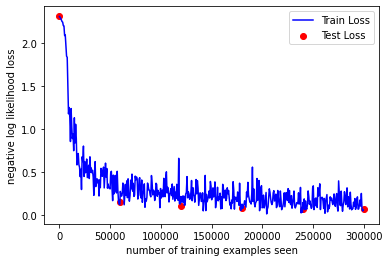


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.1776, Accuracy: 9462/10000 (95%)
Epoch 1 takes: 25.648284673690796s

Test set: Avg. loss: 0.1185, Accuracy: 9606/10000 (96%)
Epoch 2 takes: 51.19869828224182s

Test set: Avg. loss: 0.0867, Accuracy: 9735/10000 (97%)
Epoch 3 takes: 76.69970464706421s

Test set: Avg. loss: 0.0728, Accuracy: 9767/10000 (98%)
Epoch 4 takes: 102.30554008483887s

Test set: Avg. loss: 0.0671, Accuracy: 9772/10000 (98%)
Epoch 5 takes: 127.8304648399353s
Average time per epoch: 76.73682084083558s


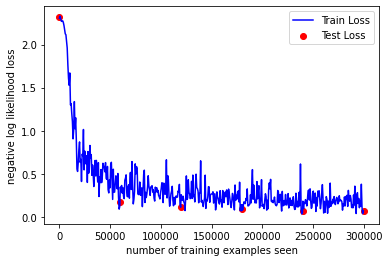


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2015, Accuracy: 9378/10000 (94%)
Epoch 1 takes: 25.54079532623291s

Test set: Avg. loss: 0.1248, Accuracy: 9618/10000 (96%)
Epoch 2 takes: 51.07197427749634s

Test set: Avg. loss: 0.1022, Accuracy: 9675/10000 (97%)
Epoch 3 takes: 76.67249727249146s

Test set: Avg. loss: 0.0836, Accuracy: 9725/10000 (97%)
Epoch 4 takes: 102.25478458404541s

Test set: Avg. loss: 0.0779, Accuracy: 9742/10000 (97%)
Epoch 5 takes: 127.7528247833252s
Average time per epoch: 76.65872926712036s


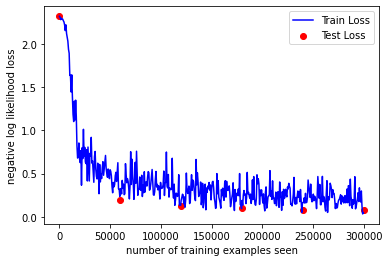


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2433, Accuracy: 9277/10000 (93%)
Epoch 1 takes: 25.6428964138031s

Test set: Avg. loss: 0.1482, Accuracy: 9540/10000 (95%)
Epoch 2 takes: 51.01526212692261s

Test set: Avg. loss: 0.1181, Accuracy: 9635/10000 (96%)
Epoch 3 takes: 76.28951668739319s

Test set: Avg. loss: 0.0999, Accuracy: 9697/10000 (97%)
Epoch 4 takes: 101.62852644920349s

Test set: Avg. loss: 0.0874, Accuracy: 9739/10000 (97%)
Epoch 5 takes: 127.04491209983826s
Average time per epoch: 76.32437920570374s


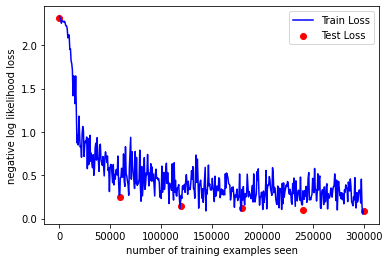


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.3213, Accuracy: 8993/10000 (90%)
Epoch 1 takes: 25.32869529724121s

Test set: Avg. loss: 0.2074, Accuracy: 9391/10000 (94%)
Epoch 2 takes: 50.61691355705261s

Test set: Avg. loss: 0.1601, Accuracy: 9501/10000 (95%)
Epoch 3 takes: 75.91093397140503s

Test set: Avg. loss: 0.1371, Accuracy: 9590/10000 (96%)
Epoch 4 takes: 101.28279137611389s

Test set: Avg. loss: 0.1212, Accuracy: 9619/10000 (96%)
Epoch 5 takes: 126.7607946395874s
Average time per epoch: 75.9801697254181s


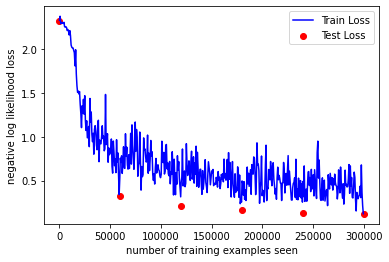


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 2.3102, Accuracy: 1010/10000 (10%)
Epoch 1 takes: 25.306464672088623s

Test set: Avg. loss: 2.3098, Accuracy: 1170/10000 (12%)
Epoch 2 takes: 50.57432579994202s

Test set: Avg. loss: 2.3095, Accuracy: 1208/10000 (12%)
Epoch 3 takes: 75.92122268676758s

Test set: Avg. loss: 2.3095, Accuracy: 1212/10000 (12%)
Epoch 4 takes: 101.37345743179321s

Test set: Avg. loss: 2.3092, Accuracy: 1201/10000 (12%)
Epoch 5 takes: 126.83152675628662s
Average time per epoch: 76.00160565376282s


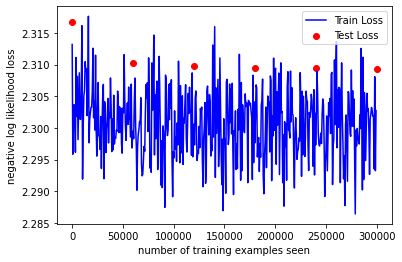

In [13]:
third_experiment_models = [BaseLineModel(dropout_rate=i) for i in np.arange(0.0, 1.2, 0.2)]
third_experiment_test_losses = []
third_experiment_accuracies = []
third_experiment_avg_time = []
for model in third_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp3_{model.dropout_rate}', f'exp3_{model.dropout_rate}_opt')
    third_experiment_test_losses.append(test_losses)
    third_experiment_accuracies.append(accuracies)
    third_experiment_avg_time.append(average_time)

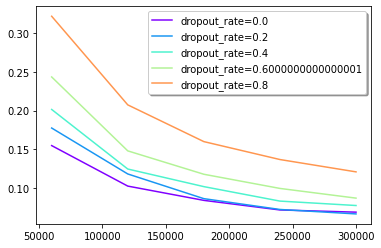

In [14]:
third_experiment_list = [i for i in np.arange(0.0, 1.2, 0.2)]
colors = cm.rainbow(np.linspace(0, 1, len(third_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, dropout_rate in zip(third_experiment_test_losses[:-1], colors[:-1], third_experiment_list[:-1]):
    ax.plot(test_counter[1:], loss[1:], color=color, label='dropout_rate=' + str(dropout_rate))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

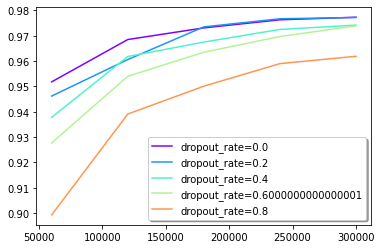

In [15]:
fig, ax = plt.subplots()
for acc, color, dropout_rate in zip(third_experiment_accuracies[:-1], colors[:-1], third_experiment_list[:-1]):
    ax.plot(test_counter[1:], acc[1:], color=color, label='dropout_rate=' + str(dropout_rate))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-4: The size of the pooling layer filters
#### Hypothesis
Bigger the pooling filter size is, smaller the accuracy should be, quicker the training process should be.
#### Observation
Models with pooling sizes 2 and 3 are almost the same, the one with 4 as the pooling size performs worse, only around 93% compared with 96% for the other two. Also, since the bigger pooling size could shrink the data faster, the training time is shorter with the increase of the pooling size.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3110, Accuracy: 1019/10000 (10%)

Test set: Avg. loss: 0.3824, Accuracy: 9002/10000 (90%)
Epoch 1 takes: 25.538896322250366s

Test set: Avg. loss: 0.2228, Accuracy: 9424/10000 (94%)
Epoch 2 takes: 50.82831954956055s

Test set: Avg. loss: 0.1811, Accuracy: 9517/10000 (95%)
Epoch 3 takes: 76.3198516368866s

Test set: Avg. loss: 0.1556, Accuracy: 9606/10000 (96%)
Epoch 4 takes: 101.64985418319702s

Test set: Avg. loss: 0.1351, Accuracy: 9650/10000 (96%)
Epoch 5 takes: 127.03750824928284s
Average time per epoch: 76.27516136169433s


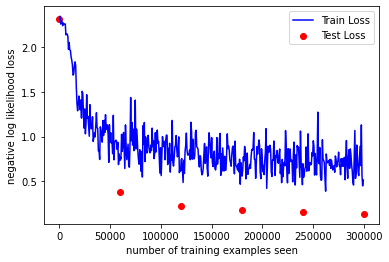


Test set: Avg. loss: 2.3165, Accuracy: 996/10000 (10%)

Test set: Avg. loss: 0.5446, Accuracy: 8665/10000 (87%)
Epoch 1 takes: 20.399049997329712s

Test set: Avg. loss: 0.2693, Accuracy: 9324/10000 (93%)
Epoch 2 takes: 40.94895339012146s

Test set: Avg. loss: 0.1830, Accuracy: 9535/10000 (95%)
Epoch 3 takes: 61.44844627380371s

Test set: Avg. loss: 0.1540, Accuracy: 9606/10000 (96%)
Epoch 4 takes: 81.89001035690308s

Test set: Avg. loss: 0.1317, Accuracy: 9631/10000 (96%)
Epoch 5 takes: 102.31234049797058s
Average time per epoch: 61.39995679855347s


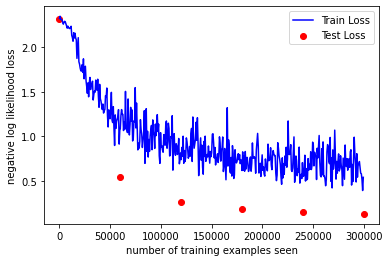


Test set: Avg. loss: 2.3047, Accuracy: 1267/10000 (13%)

Test set: Avg. loss: 0.7851, Accuracy: 7476/10000 (75%)
Epoch 1 takes: 19.095299243927002s

Test set: Avg. loss: 0.5173, Accuracy: 8421/10000 (84%)
Epoch 2 takes: 38.14753222465515s

Test set: Avg. loss: 0.4543, Accuracy: 9013/10000 (90%)
Epoch 3 takes: 57.22766351699829s

Test set: Avg. loss: 0.3772, Accuracy: 9352/10000 (94%)
Epoch 4 takes: 76.37422943115234s

Test set: Avg. loss: 0.3206, Accuracy: 9432/10000 (94%)
Epoch 5 takes: 95.37879419326782s
Average time per epoch: 57.24498171806336s


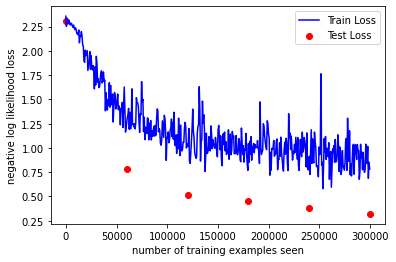

In [16]:
# When pool size euqals to 4, the input size for the first linear layer is 20, thus I have to keep the output of the linear layer as 15 here.
fourth_experiment_models = [BaseLineModel(pool_size=i, hidden_nodes=15) for i in range(2, 5, 1)]
fourth_experiment_test_losses = []
fourth_experiment_accuracies = []
fourth_experiment_avg_time = []
for model in fourth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp4_{model.pool_size}', f'exp4_{model.pool_size}_opt')
    fourth_experiment_test_losses.append(test_losses)
    fourth_experiment_accuracies.append(accuracies)
    fourth_experiment_avg_time.append(average_time)

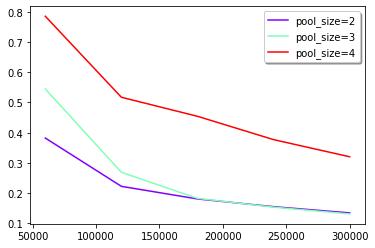

In [17]:
fourth_experiment_list = [i for i in range(2, 5, 1)]
colors = cm.rainbow(np.linspace(0, 1, len(fourth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, pool_size in zip(fourth_experiment_test_losses, colors, fourth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='pool_size=' + str(pool_size))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

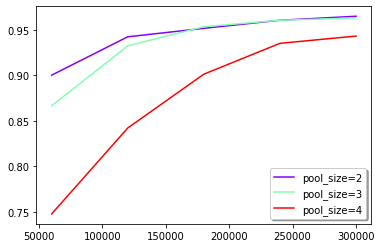

In [18]:
fig, ax = plt.subplots()
for acc, color, pool_size in zip(fourth_experiment_accuracies, colors, fourth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='pool_size=' + str(pool_size))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

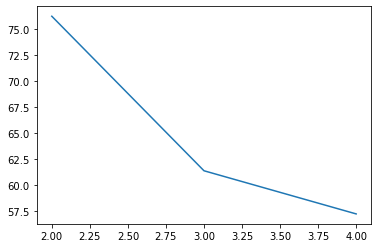

In [19]:
plt.plot(fourth_experiment_list, fourth_experiment_avg_time)
plt.show()

---
# Experiment-5: The activation function for each layer
#### Hypothesis
The tanh and ReLU should perform well, while the softmax and sigmoid may perform poorly.
#### Observation
The tanh and ReLu could be interchangeable, while the softmax and sigmoid really make the training failed. The reason could be the sigmoid and softmax saturates for large positive or large negative values, which leads to small gradients that are almost zeros and those small gradients may vanish during back-propagation.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3095, Accuracy: 958/10000 (10%)

Test set: Avg. loss: 2.3014, Accuracy: 1135/10000 (11%)
Epoch 1 takes: 26.454437732696533s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 2 takes: 52.854809522628784s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 3 takes: 79.35034322738647s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 4 takes: 105.7311019897461s

Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)
Epoch 5 takes: 132.0811629295349s
Average time per epoch: 79.29452662467956s


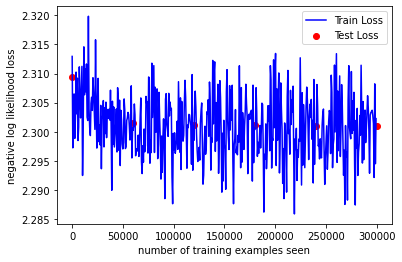


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2118, Accuracy: 9352/10000 (94%)
Epoch 1 takes: 25.469918966293335s

Test set: Avg. loss: 0.1304, Accuracy: 9611/10000 (96%)
Epoch 2 takes: 50.95515060424805s

Test set: Avg. loss: 0.1044, Accuracy: 9675/10000 (97%)
Epoch 3 takes: 76.47611904144287s

Test set: Avg. loss: 0.0876, Accuracy: 9722/10000 (97%)
Epoch 4 takes: 102.09956502914429s

Test set: Avg. loss: 0.0805, Accuracy: 9739/10000 (97%)
Epoch 5 takes: 127.72698473930359s
Average time per epoch: 76.545725440979s


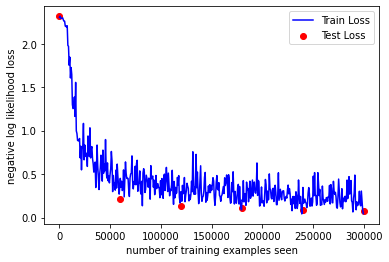

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



Test set: Avg. loss: 2.3249, Accuracy: 827/10000 (8%)

Test set: Avg. loss: 0.3354, Accuracy: 9043/10000 (90%)
Epoch 1 takes: 25.941612005233765s

Test set: Avg. loss: 0.1923, Accuracy: 9422/10000 (94%)
Epoch 2 takes: 51.75751996040344s

Test set: Avg. loss: 0.1396, Accuracy: 9572/10000 (96%)
Epoch 3 takes: 77.55731987953186s

Test set: Avg. loss: 0.1120, Accuracy: 9661/10000 (97%)
Epoch 4 takes: 103.5034122467041s

Test set: Avg. loss: 0.0957, Accuracy: 9704/10000 (97%)
Epoch 5 takes: 129.52925491333008s
Average time per epoch: 77.65792193412781s


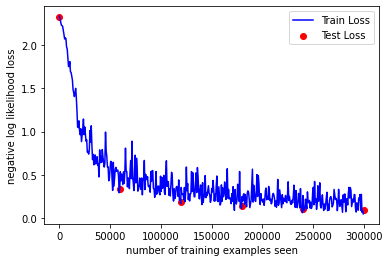

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Test set: Avg. loss: 2.3369, Accuracy: 1028/10000 (10%)

Test set: Avg. loss: 2.3008, Accuracy: 1028/10000 (10%)
Epoch 1 takes: 25.6403968334198s

Test set: Avg. loss: 2.3003, Accuracy: 1028/10000 (10%)
Epoch 2 takes: 51.196165800094604s

Test set: Avg. loss: 2.2997, Accuracy: 1028/10000 (10%)
Epoch 3 takes: 76.76300406455994s

Test set: Avg. loss: 2.2990, Accuracy: 1135/10000 (11%)
Epoch 4 takes: 102.29823207855225s

Test set: Avg. loss: 2.2982, Accuracy: 1392/10000 (14%)
Epoch 5 takes: 127.7448365688324s
Average time per epoch: 76.72886185646057s


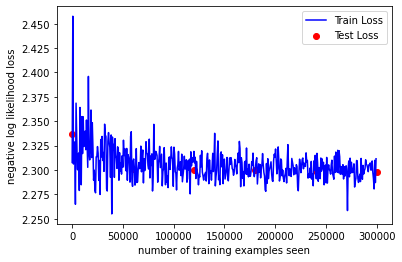

In [20]:
fifth_experiment_models = [BaseLineModel(activation_func=f) for f in [F.softmax, F.relu, F.tanh, F.sigmoid]]
fifth_experiment_test_losses = []
fifth_experiment_accuracies = []
fifth_experiment_avg_time = []
for model in fifth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp5_{model.activation_func.__name__}', f'exp5_{model.activation_func.__name__}_opt')
    fifth_experiment_test_losses.append(test_losses)
    fifth_experiment_accuracies.append(accuracies)
    fifth_experiment_avg_time.append(average_time)

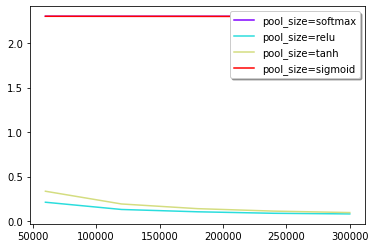

In [21]:
fifth_experiment_list = [F.softmax, F.relu, F.tanh, F.sigmoid]
colors = cm.rainbow(np.linspace(0, 1, len(fifth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, f in zip(fifth_experiment_test_losses, colors, fifth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='pool_size=' + f.__name__)
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

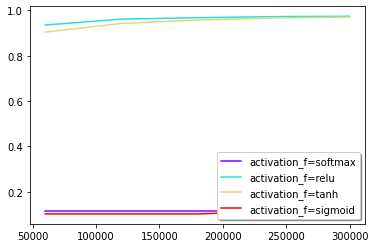

In [22]:
fig, ax = plt.subplots()
for acc, color, func in zip(fifth_experiment_accuracies, colors, fifth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='activation_f=' + str(func.__name__))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-6: The number of hidden nodes in the Dense layer
#### Hypothesis
It is hard to determine the optimal value for the hidden nodes number. There are loads of empirically-derived rules-of-thumb discussing about the choice of hidden nodes number in a network. From Jeff Heaton's saying: "he optimal size of the hidden layer is usually between the size of the input and size of the output layers". Thus, I would say the number around 170 should not perform bad.
#### Observation
From the accuracy plot, you could see the one with 30 hidden nodes perform worse than the others. The models with node number 180 or 230 or 280 perform fairly good and almost the same. Thus, I would say 180 would be my choice when training since it could reduce the dimension to a greater extent.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2996, Accuracy: 1772/10000 (18%)

Test set: Avg. loss: 0.2302, Accuracy: 9348/10000 (93%)
Epoch 1 takes: 25.36773943901062s

Test set: Avg. loss: 0.1431, Accuracy: 9539/10000 (95%)
Epoch 2 takes: 50.712321043014526s

Test set: Avg. loss: 0.1091, Accuracy: 9654/10000 (97%)
Epoch 3 takes: 76.02010226249695s

Test set: Avg. loss: 0.0898, Accuracy: 9716/10000 (97%)
Epoch 4 takes: 101.40515732765198s

Test set: Avg. loss: 0.0794, Accuracy: 9756/10000 (98%)
Epoch 5 takes: 126.82848906517029s
Average time per epoch: 76.06695122718811s


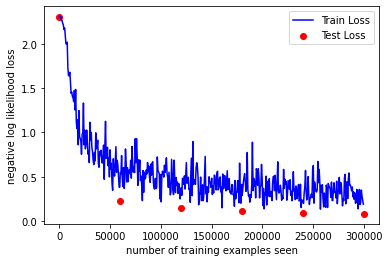


Test set: Avg. loss: 2.3084, Accuracy: 958/10000 (10%)

Test set: Avg. loss: 0.1847, Accuracy: 9416/10000 (94%)
Epoch 1 takes: 25.543893575668335s

Test set: Avg. loss: 0.1125, Accuracy: 9654/10000 (97%)
Epoch 2 takes: 51.159730434417725s

Test set: Avg. loss: 0.0854, Accuracy: 9729/10000 (97%)
Epoch 3 takes: 76.65785551071167s

Test set: Avg. loss: 0.0771, Accuracy: 9752/10000 (98%)
Epoch 4 takes: 102.21387434005737s

Test set: Avg. loss: 0.0658, Accuracy: 9791/10000 (98%)
Epoch 5 takes: 127.92474174499512s
Average time per epoch: 76.7000846862793s


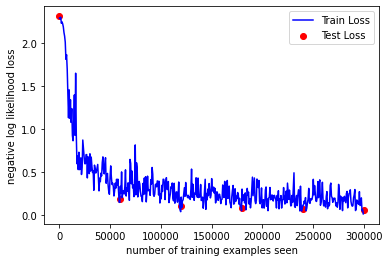


Test set: Avg. loss: 2.3024, Accuracy: 1253/10000 (13%)

Test set: Avg. loss: 0.1881, Accuracy: 9404/10000 (94%)
Epoch 1 takes: 26.34721302986145s

Test set: Avg. loss: 0.1191, Accuracy: 9616/10000 (96%)
Epoch 2 takes: 52.48152804374695s

Test set: Avg. loss: 0.0888, Accuracy: 9722/10000 (97%)
Epoch 3 takes: 78.8486430644989s

Test set: Avg. loss: 0.0771, Accuracy: 9759/10000 (98%)
Epoch 4 takes: 104.98965382575989s

Test set: Avg. loss: 0.0699, Accuracy: 9772/10000 (98%)
Epoch 5 takes: 131.3938024044037s
Average time per epoch: 78.81240239143372s


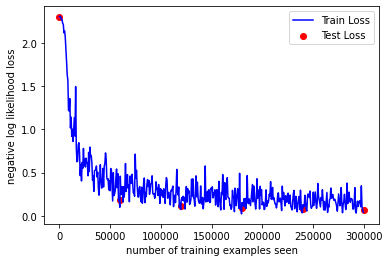


Test set: Avg. loss: 2.3148, Accuracy: 1262/10000 (13%)

Test set: Avg. loss: 0.1873, Accuracy: 9395/10000 (94%)
Epoch 1 takes: 26.2164089679718s

Test set: Avg. loss: 0.1128, Accuracy: 9656/10000 (97%)
Epoch 2 takes: 52.377054929733276s

Test set: Avg. loss: 0.0837, Accuracy: 9737/10000 (97%)
Epoch 3 takes: 78.35071182250977s

Test set: Avg. loss: 0.0744, Accuracy: 9762/10000 (98%)
Epoch 4 takes: 104.31071996688843s

Test set: Avg. loss: 0.0625, Accuracy: 9819/10000 (98%)
Epoch 5 takes: 130.1251220703125s
Average time per epoch: 78.27629127502442s


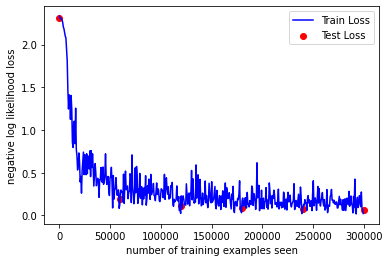


Test set: Avg. loss: 2.3021, Accuracy: 1693/10000 (17%)

Test set: Avg. loss: 0.1915, Accuracy: 9407/10000 (94%)
Epoch 1 takes: 26.31054139137268s

Test set: Avg. loss: 0.1145, Accuracy: 9623/10000 (96%)
Epoch 2 takes: 52.42804265022278s

Test set: Avg. loss: 0.0863, Accuracy: 9725/10000 (97%)
Epoch 3 takes: 78.49674320220947s

Test set: Avg. loss: 0.0713, Accuracy: 9776/10000 (98%)
Epoch 4 takes: 104.75744104385376s

Test set: Avg. loss: 0.0616, Accuracy: 9806/10000 (98%)
Epoch 5 takes: 131.16490650177002s
Average time per epoch: 78.63175048828126s


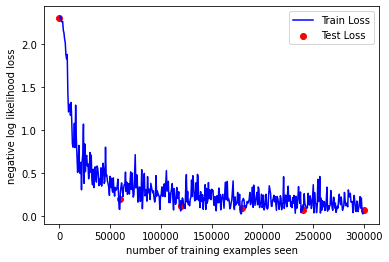


Test set: Avg. loss: 2.3074, Accuracy: 992/10000 (10%)

Test set: Avg. loss: 0.1778, Accuracy: 9439/10000 (94%)
Epoch 1 takes: 26.43799376487732s

Test set: Avg. loss: 0.1140, Accuracy: 9655/10000 (97%)
Epoch 2 takes: 52.85703730583191s

Test set: Avg. loss: 0.0875, Accuracy: 9731/10000 (97%)
Epoch 3 takes: 79.29618763923645s

Test set: Avg. loss: 0.0729, Accuracy: 9770/10000 (98%)
Epoch 4 takes: 105.66575813293457s

Test set: Avg. loss: 0.0610, Accuracy: 9811/10000 (98%)
Epoch 5 takes: 131.84586358070374s
Average time per epoch: 79.22082018852234s


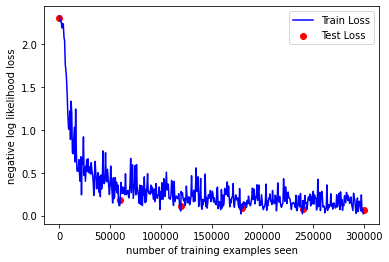

In [23]:
sixth_experiment_models = [BaseLineModel(hidden_nodes=i) for i in range(30, 320, 50)]
sixth_experiment_test_losses = []
sixth_experiment_accuracies = []
sixth_experiment_avg_time = []
for model in sixth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp6_{model.hidden_nodes}', f'exp6_{model.hidden_nodes}_opt')
    sixth_experiment_test_losses.append(test_losses)
    sixth_experiment_accuracies.append(accuracies)
    sixth_experiment_avg_time.append(average_time)

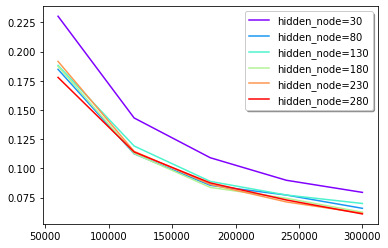

In [24]:
sixth_experiment_list = [i for i in range(30, 320, 50)]
colors = cm.rainbow(np.linspace(0, 1, len(sixth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, hidden_node in zip(sixth_experiment_test_losses, colors, sixth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='hidden_node=' + str(hidden_node))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

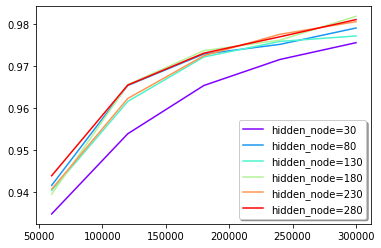

In [25]:
fig, ax = plt.subplots()
for acc, color, hidden_node in zip(sixth_experiment_accuracies, colors, sixth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='hidden_node=' + str(hidden_node))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

---
# Experiment-7: The number of epochs of training
#### Hypothesis
The number of epoch could help increase the accuracy, while it does not change much after the model converges.
#### Observation
I set the number of epoch as 8 and the results shows the loss is quite small after the second or third epoch, which is because the training dataset is quite small for this task. The training epoch after that does help to reduce the loss value, but it really does not change much.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2159, Accuracy: 9341/10000 (93%)
Epoch 1 takes: 25.407704830169678s

Test set: Avg. loss: 0.1305, Accuracy: 9586/10000 (96%)
Epoch 2 takes: 50.75158381462097s

Test set: Avg. loss: 0.1061, Accuracy: 9684/10000 (97%)
Epoch 3 takes: 76.60159873962402s

Test set: Avg. loss: 0.0908, Accuracy: 9730/10000 (97%)
Epoch 4 takes: 102.41885042190552s

Test set: Avg. loss: 0.0828, Accuracy: 9743/10000 (97%)
Epoch 5 takes: 128.23170566558838s

Test set: Avg. loss: 0.0703, Accuracy: 9769/10000 (98%)
Epoch 6 takes: 154.2599151134491s

Test set: Avg. loss: 0.0667, Accuracy: 9776/10000 (98%)
Epoch 7 takes: 180.23997616767883s

Test set: Avg. loss: 0.0605, Accuracy: 9798/10000 (98%)
Epoch 8 takes: 206.1327781677246s
Average time per epoch: 115.50571510195732s


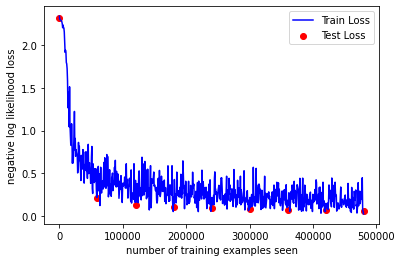

In [26]:
large_epoch_model = BaseLineModel(training_epoch=8)
train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(large_epoch_model, 'exp7', 'exp7')

---
# Experiment-8: The batch size while training
#### Hypothesis
Bigger the batch size, smaller accuracy the model should perform, faster the training process.
#### Observation
With the increase of the batch size, the accuracy of the model decrease. Also, the model with smaller batch size converges faster than the bigger ones. As for the training time, bigger batch size means less update during training, which obviously decrease the time for training.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.0985, Accuracy: 9697/10000 (97%)
Epoch 1 takes: 35.91783595085144s

Test set: Avg. loss: 0.0692, Accuracy: 9792/10000 (98%)
Epoch 2 takes: 71.77903771400452s

Test set: Avg. loss: 0.0630, Accuracy: 9792/10000 (98%)
Epoch 3 takes: 107.63656401634216s

Test set: Avg. loss: 0.0592, Accuracy: 9820/10000 (98%)
Epoch 4 takes: 143.53048491477966s

Test set: Avg. loss: 0.0563, Accuracy: 9825/10000 (98%)
Epoch 5 takes: 179.50611400604248s
Average time per epoch: 107.67419633865356s


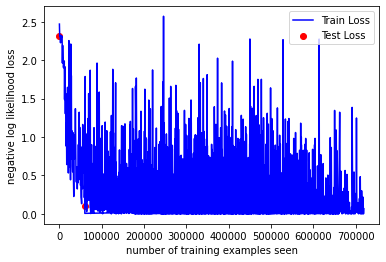


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.1079, Accuracy: 9684/10000 (97%)
Epoch 1 takes: 30.156445741653442s

Test set: Avg. loss: 0.0811, Accuracy: 9754/10000 (98%)
Epoch 2 takes: 60.42495608329773s

Test set: Avg. loss: 0.0650, Accuracy: 9800/10000 (98%)
Epoch 3 takes: 90.70714330673218s

Test set: Avg. loss: 0.0603, Accuracy: 9825/10000 (98%)
Epoch 4 takes: 120.9933590888977s

Test set: Avg. loss: 0.0605, Accuracy: 9820/10000 (98%)
Epoch 5 takes: 151.2432017326355s
Average time per epoch: 90.70516333580017s


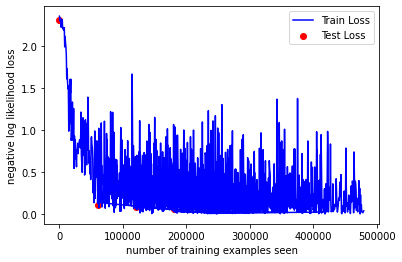


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.1540, Accuracy: 9531/10000 (95%)
Epoch 1 takes: 27.021872997283936s

Test set: Avg. loss: 0.0967, Accuracy: 9692/10000 (97%)
Epoch 2 takes: 54.016663551330566s

Test set: Avg. loss: 0.0797, Accuracy: 9753/10000 (98%)
Epoch 3 takes: 81.16179752349854s

Test set: Avg. loss: 0.0679, Accuracy: 9786/10000 (98%)
Epoch 4 takes: 108.32217979431152s

Test set: Avg. loss: 0.0626, Accuracy: 9804/10000 (98%)
Epoch 5 takes: 135.3528015613556s
Average time per epoch: 81.17540845870971s


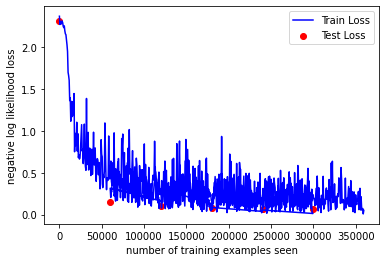


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.2191, Accuracy: 9331/10000 (93%)
Epoch 1 takes: 26.019665241241455s

Test set: Avg. loss: 0.1345, Accuracy: 9590/10000 (96%)
Epoch 2 takes: 52.02402901649475s

Test set: Avg. loss: 0.1079, Accuracy: 9677/10000 (97%)
Epoch 3 takes: 78.02608251571655s

Test set: Avg. loss: 0.0934, Accuracy: 9699/10000 (97%)
Epoch 4 takes: 103.98899102210999s

Test set: Avg. loss: 0.0808, Accuracy: 9746/10000 (97%)
Epoch 5 takes: 129.96686458587646s
Average time per epoch: 78.00528717041016s


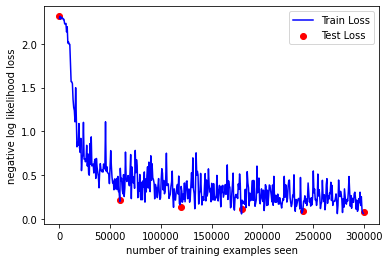


Test set: Avg. loss: 2.3168, Accuracy: 664/10000 (7%)

Test set: Avg. loss: 0.3363, Accuracy: 9012/10000 (90%)
Epoch 1 takes: 25.384507656097412s

Test set: Avg. loss: 0.1978, Accuracy: 9417/10000 (94%)
Epoch 2 takes: 50.6862998008728s

Test set: Avg. loss: 0.1510, Accuracy: 9530/10000 (95%)
Epoch 3 takes: 75.98006629943848s

Test set: Avg. loss: 0.1245, Accuracy: 9622/10000 (96%)
Epoch 4 takes: 101.46720957756042s

Test set: Avg. loss: 0.1088, Accuracy: 9663/10000 (97%)
Epoch 5 takes: 126.8982183933258s
Average time per epoch: 76.08349061012268s


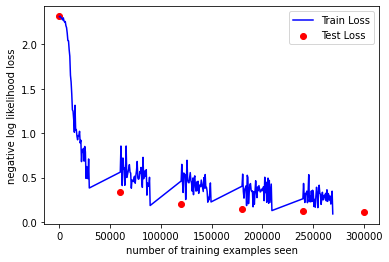

In [27]:
eighth_experiment_models = [BaseLineModel(batch_size=2**i) for i in range(3, 8, 1)]
eighth_experiment_test_losses = []
eighth_experiment_accuracies = []
eighth_experiment_avg_time = []
for model in eighth_experiment_models:
    train_losses, train_counter, test_counter, test_losses, accuracies, total_time, average_time = train_process(model, f'exp8_{model.batch_size_train}', f'exp8_{model.batch_size_train}_opt')
    eighth_experiment_test_losses.append(test_losses)
    eighth_experiment_accuracies.append(accuracies)
    eighth_experiment_avg_time.append(average_time)

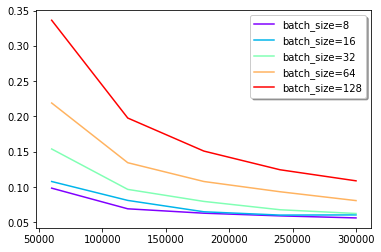

In [28]:
eighth_experiment_list = [2**i for i in range(3, 8, 1)]
colors = cm.rainbow(np.linspace(0, 1, len(eighth_experiment_test_losses)))

fig, ax = plt.subplots()
for loss, color, batch_size in zip(eighth_experiment_test_losses, colors, eighth_experiment_list):
    ax.plot(test_counter[1:], loss[1:], color=color, label='batch_size=' + str(batch_size))
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

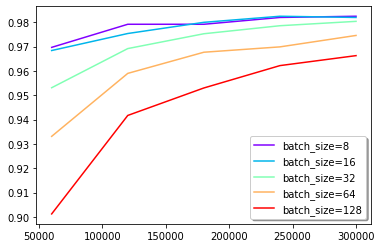

In [29]:
fig, ax = plt.subplots()
for acc, color, batch_size in zip(eighth_experiment_accuracies, colors, eighth_experiment_list):
    ax.plot(test_counter[1:], acc[1:], color=color, label='batch_size=' + str(batch_size))
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

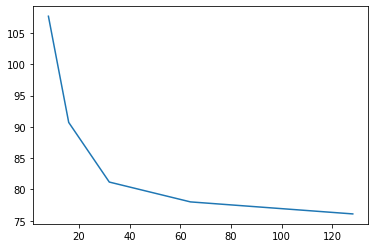

In [30]:
plt.plot(eighth_experiment_list, eighth_experiment_avg_time)
plt.show()